In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook

#freeze random for testing results
np.random.seed(5)

In [2]:
# 1. Dataset uploading and preprocessing

data = pd.read_csv("ionosphere_data.csv", header=None)
data.iloc[:, 34] = data.iloc[:, 34].replace({'g': 1, 'b': 0})
# shuffling data
shuffled_data = data.sample(frac=1).astype(float)

# dividing data into training and test samples
train_data = shuffled_data.iloc[:int(0.8 * len(data))]
test_data = shuffled_data.iloc[int(0.8 * len(data)):]

# highlighting features and target variable
X_train = train_data.drop(train_data.columns[34], axis=1).values
y_train = train_data[train_data.columns[34]].values.reshape(-1,1)
X_test = test_data.drop(train_data.columns[34], axis=1).values
y_test = test_data[train_data.columns[34]].values.reshape(-1,1)

def create_mini_batches(X, y, batch_size):
    m = X.shape[0]
    mini_batches = []
    
    # Shuffle both X and y in unison
    permutation = np.random.permutation(m)
    X_shuffled = X[permutation]
    y_shuffled = y[permutation]

    num_complete_batches = m // batch_size
    for k in range(num_complete_batches):
        batch_X = X_shuffled[k * batch_size : (k + 1) * batch_size]
        batch_y = y_shuffled[k * batch_size : (k + 1) * batch_size]
        mini_batches.append((batch_X, batch_y))
    
    # Handling the last batch if it's smaller than batch_size
    if m % batch_size != 0:
        batch_X = X_shuffled[batch_size * num_complete_batches:]
        batch_y = y_shuffled[batch_size * num_complete_batches:]
        mini_batches.append((batch_X, batch_y))
    
    return mini_batches


In [3]:
# 2. Neural Network Functions

# initializing layer weights and bias
def initialize_layer(input_dim, output_dim):
    weights = np.random.uniform(-1/np.sqrt(input_dim), 1/np.sqrt(input_dim), (input_dim, output_dim))
    biases = np.zeros((1, output_dim))
    return weights, biases

# activation function 

def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return 1.0 - np.tanh(x)**2

def sigmoid(x):    
      return 1 / (1 + np.exp(-x))

def dsigmoid(x):
      return sigmoid(x) * (1 - sigmoid(x))

def binary_crossentropy_loss(p_pred, y_true):
    epsilon = 1e-15
    return -y_true * np.log(p_pred + epsilon) - (1 - y_true) * np.log(1 - p_pred + epsilon)

def dbinary_crossentropy_loss(p_pred, y_true):
    return (-y_true / p_pred) + (1 - y_true) / (1 - p_pred)

def plot_latent_features_2d(features, y, title):
    plt.figure(figsize=(10, 6))
    
    assert features.shape[1] >= 2, "You need at least 2 dimensions for a 2D plot"
    
    plt.scatter(features[y.reshape(-1) == 0][:, 0], features[y.reshape(-1) == 0][:, 1], color='blue', label='Class 1')
    plt.scatter(features[y.reshape(-1) == 1][:, 0], features[y.reshape(-1) == 1][:, 1], color='red', label='Class 2')
    
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_latent_features_3d(features, y, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    assert features.shape[1] >= 3, "You need at least 3 dimensions for a 3D plot"
    
    ax.scatter(features[y.reshape(-1) == 0][:, 0], features[y.reshape(-1) == 0][:, 1], features[y.reshape(-1) == 0][:, 2], color='blue', label='Class 1')
    ax.scatter(features[y.reshape(-1) == 1][:, 0], features[y.reshape(-1) == 1][:, 1], features[y.reshape(-1) == 1][:, 2], color='red', label='Class 2')
    
    ax.set_title(title)
    ax.legend()
    plt.show()
    
# layers and sizes
#input layer
input_dim = X_train.shape[1]
# hidden layer
hidden_dim = 3
# output layer
output_dim = y_train.shape[1]

# weights and bias for hidden and output layers
W1, b1 = initialize_layer(input_dim, hidden_dim)
W2, b2 = initialize_layer(hidden_dim, output_dim)

In [4]:
# 3. Training!

learning_rate = 0.05 
epochs = 5001
lmbda = 0.045

losses = []
losses_test = []
accuracies = []
accuracies_test = []

latent_features_10 = None
latent_features_5000 = None
all_latent_features = np.zeros((len(y_train), W1.shape[1]))

batch_size = 8

for epoch in range(epochs):
    running_loss = 0
    running_accuracy = 0
    mini_batches = create_mini_batches(X_train, y_train, batch_size)
    
    batch_num = 0

    for batch_X, batch_y in mini_batches:

        # forward propagation
        Z1 = np.dot(batch_X, W1) + b1
        A1 = tanh(Z1)
        Z2 = np.dot(A1, W2) + b2
        A2 = sigmoid(Z2)

        # backward propagation
        dA2 = dbinary_crossentropy_loss(A2, batch_y)
        dZ2 = dsigmoid(Z2) * dA2
        dW2 = np.dot(A1.T, dZ2) / len(batch_X)  # use batch_X here
        db2 = np.sum(dZ2, axis=0, keepdims=True) / len(batch_X)  # use batch_X here

        # calc gradients to update weights and biases
        dA1 = np.dot(dZ2, W2.T)
        dZ1 = dA1 * dtanh(Z1)
        dW1 = np.dot(batch_X.T, dZ1) / len(batch_X)  # use batch_X here
        db1 = np.sum(dZ1, axis=0, keepdims=True) / len(batch_X)  # use batch_X here

        # update weights and biases
        W1 -= learning_rate * (dW1 + lmbda * W1)
        b1 -= learning_rate * db1
        W2 -= learning_rate * (dW2 + lmbda * W2)
        b2 -= learning_rate * db2

        loss = binary_crossentropy_loss(A2, batch_y).mean()
        running_loss += loss
        
        start_idx = batch_num * batch_size
        end_idx = start_idx + batch_size
        all_latent_features[start_idx:end_idx] = A1
        

        A2 = np.where(A2 < 0.5, 0, 1)
        correct_predictions = np.sum(A2 == batch_y)
        total_predictions = batch_y.shape[0]
        accuracy = correct_predictions / total_predictions
        running_accuracy += accuracy 

        
        batch_num += 1

        # saving losses
#         losses.append(loss)
    
    avg_loss = running_loss / len(mini_batches)
    losses.append(avg_loss)
    avg_accuracies = running_accuracy / len(mini_batches)
    accuracies.append(avg_accuracies)
    
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}/{epochs} - Loss train: {avg_loss}")
        
    if epoch == 10:
        Z1 = np.dot(X_train, W1) + b1
        A1 = tanh(Z1)
        Z2 = np.dot(A1, W2) + b2
        A2 = sigmoid(Z2)
        latent_features_10 = A1.copy()

    elif epoch == 5000:
        Z1 = np.dot(X_train, W1) + b1
        A1 = tanh(Z1)
        Z2 = np.dot(A1, W2) + b2
        A2 = sigmoid(Z2)
        latent_features_5000 = A1.copy()
        
    # forward propagation
    Z1 = np.dot(X_test, W1) + b1
    A1 = tanh(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)
    
    loss_test = binary_crossentropy_loss(A2, y_test).mean()
    losses_test.append(loss_test)
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}/{epochs} - Loss test: {loss_test}")
    


Epoch 0/5001 - Loss train: 0.6231028312589402
Epoch 0/5001 - Loss test: 0.566523603719396
Epoch 500/5001 - Loss train: 0.332736570106193
Epoch 500/5001 - Loss test: 0.33158257775920774
Epoch 1000/5001 - Loss train: 0.3354111169513527
Epoch 1000/5001 - Loss test: 0.33053534226020204
Epoch 1500/5001 - Loss train: 0.3314836759702826
Epoch 1500/5001 - Loss test: 0.3308678362524617
Epoch 2000/5001 - Loss train: 0.3324577890321363
Epoch 2000/5001 - Loss test: 0.3393117633651671
Epoch 2500/5001 - Loss train: 0.3325580898717011
Epoch 2500/5001 - Loss test: 0.33525236284135
Epoch 3000/5001 - Loss train: 0.33329260796275195
Epoch 3000/5001 - Loss test: 0.3317311892394133
Epoch 3500/5001 - Loss train: 0.3326971046575868
Epoch 3500/5001 - Loss test: 0.3310859219489338
Epoch 4000/5001 - Loss train: 0.33349511935798487
Epoch 4000/5001 - Loss test: 0.3352844799617615
Epoch 4500/5001 - Loss train: 0.33267889463396194
Epoch 4500/5001 - Loss test: 0.33193724692353216
Epoch 5000/5001 - Loss train: 0.3292

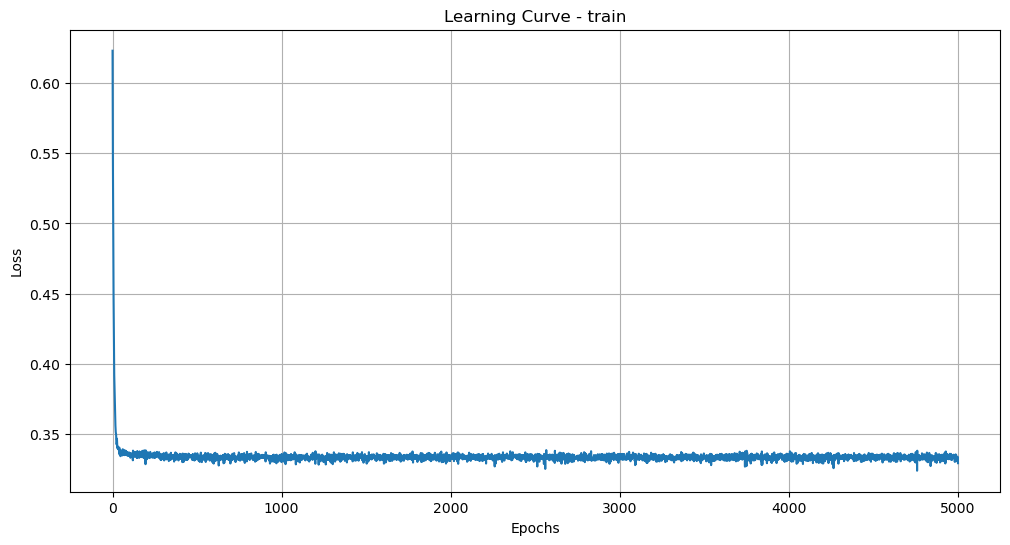

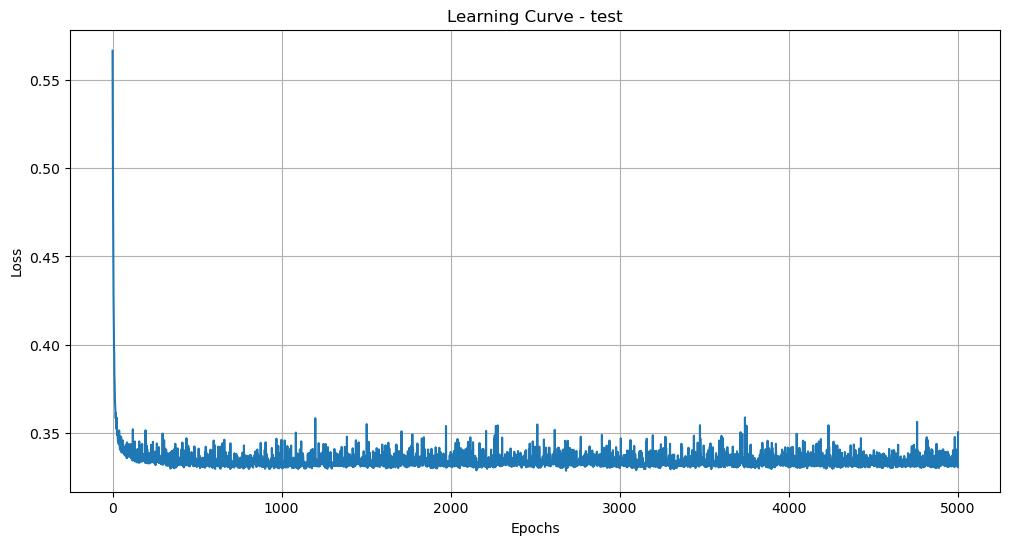

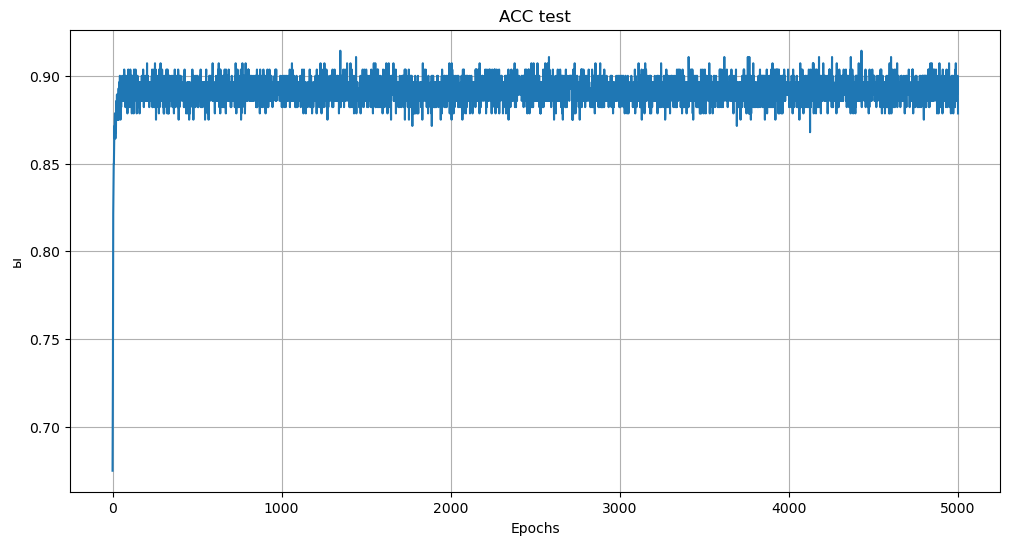

In [5]:
# visualize the learning curve (train data)
plt.figure(figsize=(12, 6))
plt.plot(losses)
plt.title("Learning Curve - train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# visualize the learning curve (test data)
plt.figure(figsize=(12, 6))
plt.plot(losses_test)
plt.title("Learning Curve - test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# visualize the learning curve (test data)
plt.figure(figsize=(12, 6))
plt.plot(accuracies)
plt.title("ACC test")
plt.xlabel("Epochs")
plt.ylabel("ы")
plt.grid(True)
plt.show()

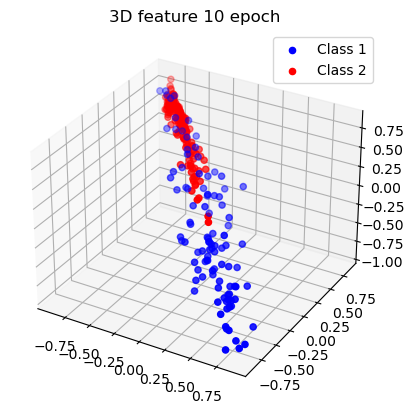

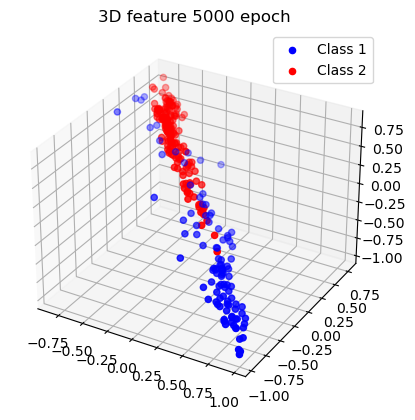

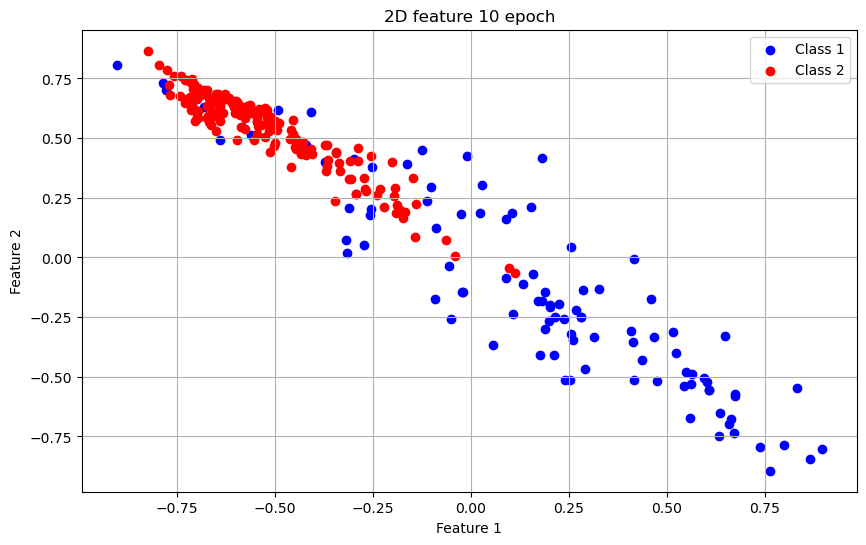

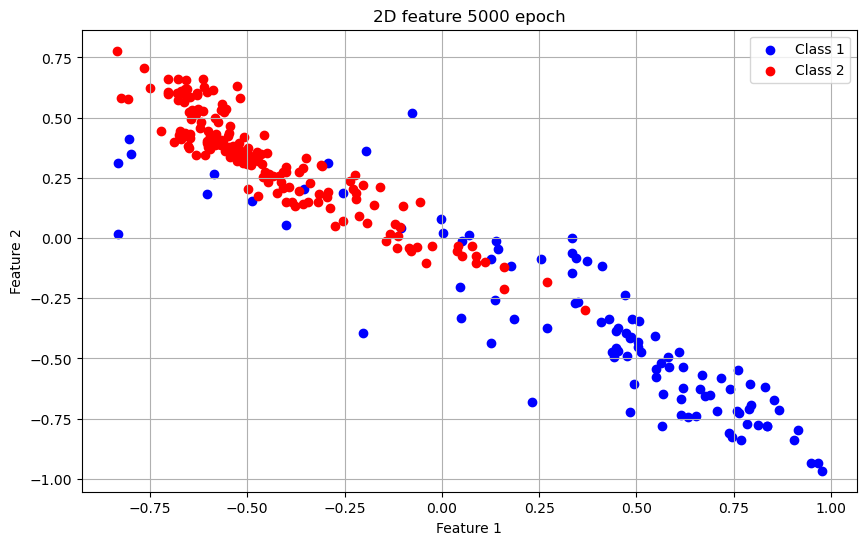

In [6]:
plot_latent_features_3d(latent_features_10, y_train, "3D feature 10 epoch")
plot_latent_features_3d(latent_features_5000, y_train, "3D feature 5000 epoch")

plot_latent_features_2d(latent_features_10, y_train, "2D feature 10 epoch")
plot_latent_features_2d(latent_features_5000, y_train, "2D feature 5000 epoch")

Training BCE: 0.3390311144060863
Training Accuracy: 90.00%
Predicted 0: 1.00, Actual: 1.0
-------
Predicted 1: 1.00, Actual: 1.0
-------
Predicted 2: 0.00, Actual: 0.0
-------
Predicted 3: 1.00, Actual: 1.0
-------
Predicted 4: 1.00, Actual: 1.0
-------
Predicted 5: 0.00, Actual: 0.0
-------
Predicted 6: 0.00, Actual: 0.0
-------
Predicted 7: 1.00, Actual: 1.0
-------
Predicted 8: 1.00, Actual: 1.0
-------
Predicted 9: 1.00, Actual: 1.0
-------


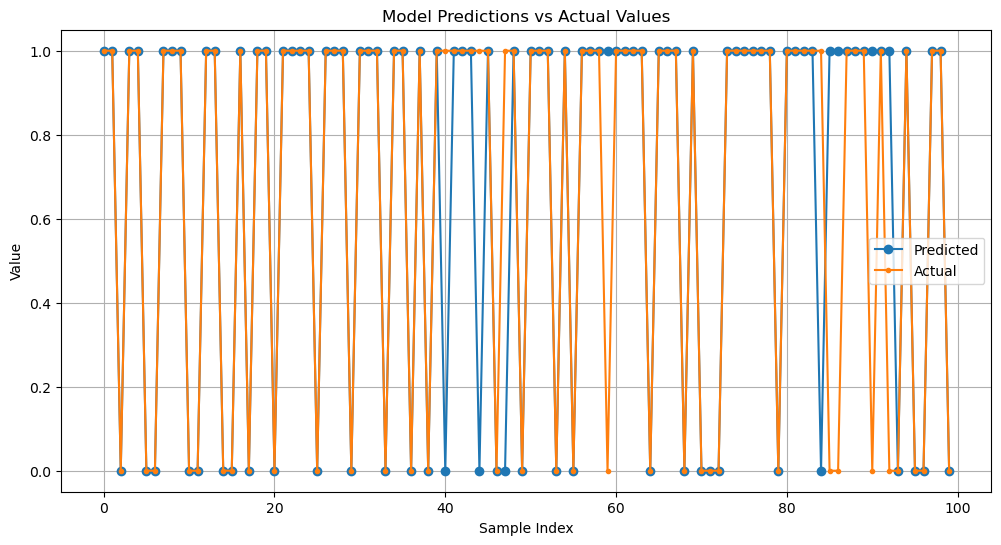

In [7]:
Z1 = np.dot(X_train, W1) + b1
A1 = tanh(Z1)
Z2 = np.dot(A1, W2) + b2
A2 = sigmoid(Z2)

# calculate bce for train data
bce = binary_crossentropy_loss(A2, y_train).mean()
print(f"Training BCE: {bce}")

# Threshold the predictions to 0 or 1 based on the 0.5 cutoff
A2 = np.where(A2 < 0.5, 0, 1)

# Calculate accuracy
correct_predictions = np.sum(A2 == y_train)
total_predictions = y_train.shape[0]
accuracy = correct_predictions / total_predictions
print(f"Training Accuracy: {accuracy * 100:.2f}%")



for i in range(10):
    print(f"Predicted {i}: {A2[i][0]:.2f}, Actual: {y_train[i][0]}")
    print("-------")
    
# visualize the predict model against actual values (train data)
plt.figure(figsize=(12, 6))
plt.plot(A2[:100], label="Predicted", linestyle='-', marker='o')
plt.plot(y_train[:100], label="Actual", linestyle='-', marker='.')
plt.title("Model Predictions vs Actual Values")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# 4. Testing the Neural Network
# forward propagation for test samples
Z1 = np.dot(X_test, W1) + b1
A1 = tanh(Z1)
Z2 = np.dot(A1, W2) + b2
A2 = sigmoid(Z2)



# calculate mse for test data
bce = binary_crossentropy_loss(A2, y_test).mean()
print(f"Test BCE: {bce}")

# Threshold the predictions to 0 or 1 based on the 0.5 cutoff
A2 = np.where(A2 < 0.5, 0, 1)

# Calculate accuracy
correct_predictions = np.sum(A2 == y_test)
total_predictions = y_test.shape[0]
accuracy = correct_predictions / total_predictions
print(f"Test Accuracy: {accuracy * 100:.2f}%")

for i in range(10):
    print(f"Predicted {i}: {A2[i][0]:.2f}, Actual: {y_test[i][0]}")
    print("-------")

Test BCE: 0.35043703832617706
Test Accuracy: 90.14%
Predicted 0: 1.00, Actual: 0.0
-------
Predicted 1: 1.00, Actual: 1.0
-------
Predicted 2: 1.00, Actual: 1.0
-------
Predicted 3: 1.00, Actual: 1.0
-------
Predicted 4: 0.00, Actual: 0.0
-------
Predicted 5: 1.00, Actual: 1.0
-------
Predicted 6: 0.00, Actual: 0.0
-------
Predicted 7: 0.00, Actual: 0.0
-------
Predicted 8: 1.00, Actual: 1.0
-------
Predicted 9: 1.00, Actual: 1.0
-------


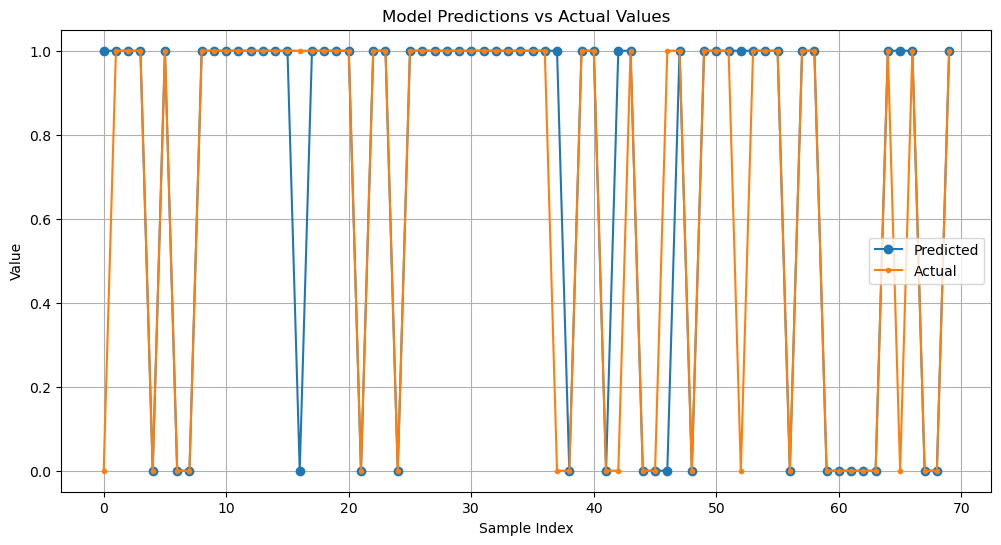

In [9]:
# visualize the predict model against actual values (test data)
plt.figure(figsize=(12, 6))
plt.plot(A2[:70], label="Predicted", linestyle='-', marker='o')
plt.plot(y_test[:70], label="Actual", linestyle='-', marker='.')
plt.title("Model Predictions vs Actual Values")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()
